## IMPORTING LIBRARIES 

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Model persistence
import joblib

# Jupyter notebook utilities
from IPython.display import display
from IPython import get_ipython

# MLflow tracking
import mlflow
import mlflow.sklearn


## importing data 


In [2]:



df = pd.read_csv('healthcare_dataset.csv')

# 👁️ Display the first few rows
df.head()


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [3]:
df["Medical Condition"].unique()


array(['Cancer', 'Obesity', 'Diabetes', 'Asthma', 'Hypertension',
       'Arthritis'], dtype=object)

## Initial assessment


In [4]:
#Initial assessment
print(f"Dataset shape: {df.shape}")
print("\nData types:\n", df.dtypes)
print("\nSample data:\n", df.head())

Dataset shape: (55500, 15)

Data types:
 Name                   object
Age                     int64
Gender                 object
Blood Type             object
Medical Condition      object
Date of Admission      object
Doctor                 object
Hospital               object
Insurance Provider     object
Billing Amount        float64
Room Number             int64
Admission Type         object
Discharge Date         object
Medication             object
Test Results           object
dtype: object

Sample data:
             Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   


In [5]:
# Check for missing values
print("Missing values :\n", df.isnull().sum())

Missing values :
 Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64


In [6]:
# Check for duplicate rows
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 534


## removing duplicates 

In [7]:
# Remove duplicates keeping the first occurrence
df.drop_duplicates(inplace=True)

## Normalization

In [8]:
#Select numerical columns for normalization
numerical_cols = ['Billing Amount']

# Apply Min-Max normalization
for col in numerical_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col + '_normalized'] = (df[col] - min_val) / (max_val - min_val)



print(df.head())


            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medication  \
0    18856.281306    

## Data selection

In [9]:
# Select patients over 60 years old
elderly_patients = df[df['Age'] > 60]

# Select admissions with billing amount over 90th percentile
high_billing = df[df['Billing Amount'] > df['Billing Amount'].quantile(0.9)]

# Select female patients with a specific condition
female_diabetes = df[(df['Gender'] == 'Female') & (df['Medical Condition'] == 'Diabetes')]


In [10]:
# Display selected data samples
display(elderly_patients.head())
display(high_billing.head())
display(female_diabetes.head())

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Billing Amount_normalized
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,0.650904
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,0.547053
8,JASmINe aGuIlaR,82,Male,AB+,Asthma,2020-07-01,Daniel Ferguson,Sons Rich and,Cigna,50119.222792,316,Elective,2020-07-14,Aspirin,Abnormal,0.951709
10,mIchElLe daniELs,72,Male,O+,Cancer,2020-04-19,John Duncan,Schaefer-Porter,Medicare,12576.795609,394,Urgent,2020-04-22,Paracetamol,Normal,0.266287
12,connOR HANsEn,75,Female,A+,Diabetes,2019-12-12,Kenneth Fletcher,"Powers Miller, and Flores",Cigna,43282.283358,134,Emergency,2019-12-28,Penicillin,Abnormal,0.826885


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Billing Amount_normalized
5,EMILY JOHNSOn,36,Male,A+,Asthma,2023-12-20,Taylor Newton,Nunez-Humphrey,UnitedHealthcare,48145.110951,389,Urgent,2023-12-24,Ibuprofen,Normal,0.915667
7,CHrisTInA MARtinez,20,Female,A+,Cancer,2021-12-28,Suzanne Thomas,"Powell Robinson and Valdez,",Cigna,45820.462722,277,Emergency,2022-01-07,Paracetamol,Inconclusive,0.873225
8,JASmINe aGuIlaR,82,Male,AB+,Asthma,2020-07-01,Daniel Ferguson,Sons Rich and,Cigna,50119.222792,316,Elective,2020-07-14,Aspirin,Abnormal,0.951709
30,ThOMAS MartInEZ,34,Male,B-,Asthma,2019-08-18,Jacob Huynh,Hart Ltd,Cigna,47909.128810,371,Urgent,2019-09-01,Ibuprofen,Inconclusive,0.911358
35,DAvID AndErSON,25,Female,AB+,Asthma,2021-01-07,Emma Allison,Sons and Cox,Medicare,45453.418546,228,Elective,2021-01-26,Lipitor,Abnormal,0.866524


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Billing Amount_normalized
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,0.728798
6,edwArD EDWaRDs,21,Female,AB-,Diabetes,2020-11-03,Kelly Olson,Group Middleton,Medicare,19580.872345,389,Emergency,2020-11-15,Paracetamol,Inconclusive,0.394162
12,connOR HANsEn,75,Female,A+,Diabetes,2019-12-12,Kenneth Fletcher,"Powers Miller, and Flores",Cigna,43282.283358,134,Emergency,2019-12-28,Penicillin,Abnormal,0.826885
27,mr. KenNEth MoORE,34,Female,A+,Diabetes,2022-06-21,James Ellis,Serrano-Dixon,UnitedHealthcare,18834.801341,157,Emergency,2022-06-30,Lipitor,Abnormal,0.380541
34,NicOlE RodriGUEz,30,Female,AB+,Diabetes,2020-01-17,Lynn Young,Poole Inc,Blue Cross,8408.949354,285,Emergency,2020-02-10,Lipitor,Normal,0.190194


## Data Analysis

In [11]:
# Descriptive statistics for numerical columns
print("Descriptive Statistics:")
print(df.describe())

Descriptive Statistics:
                Age  Billing Amount   Room Number  Billing Amount_normalized
count  54966.000000    54966.000000  54966.000000               54966.000000
mean      51.535185    25544.306284    301.124404                   0.503038
std       19.605661    14208.409711    115.223143                   0.259406
min       13.000000    -2008.492140    101.000000                   0.000000
25%       35.000000    13243.718641    202.000000                   0.278463
50%       52.000000    25542.749145    302.000000                   0.503010
75%       68.000000    37819.858159    401.000000                   0.727156
max       89.000000    52764.276736    500.000000                   1.000000


In [12]:
# Count of each medical condition
print("\nMedical Condition Distribution:")
print(df['Medical Condition'].value_counts())


Medical Condition Distribution:
Medical Condition
Arthritis       9218
Diabetes        9216
Hypertension    9151
Obesity         9146
Cancer          9140
Asthma          9095
Name: count, dtype: int64


In [13]:
# Average billing amount per hospital
avg_billing_hospital = df.groupby('Hospital')['Billing Amount'].mean().sort_values(ascending=False)
print("\nAverage Billing Amount by Hospital:")
print(avg_billing_hospital)


Average Billing Amount by Hospital:
Hospital
Hernandez-Morton                 52373.032374
Walker-Garcia                    52170.036854
Ruiz-Anthony                     52154.237722
George-Gonzalez                  52102.240889
Rocha-Carter                     52092.669896
                                     ...     
Hunter-Hughes                    -1018.245371
Lawrence and Cooper Saunders,    -1129.997176
Clements-Bowman                  -1277.645337
Medina and Elliott Stewart,      -1316.618581
Juarez-Clark                     -2008.492140
Name: Billing Amount, Length: 39876, dtype: float64


In [14]:
# Convert date columns to datetime, handling potential errors
date_cols = ['Date of Admission', 'Discharge Date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors to NaT

# Calculate length of stay, excluding rows with invalid dates
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# Remove rows with NaT (Not a Time) values in 'Length of Stay' if needed
df.dropna(subset=['Length of Stay'], inplace=True)

In [15]:
# Average length of stay in days
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
avg_stay = df['Length of Stay'].mean()
print(f"\nAverage Length of Stay: {avg_stay:.2f} days")


Average Length of Stay: 15.50 days


## Data visulaization

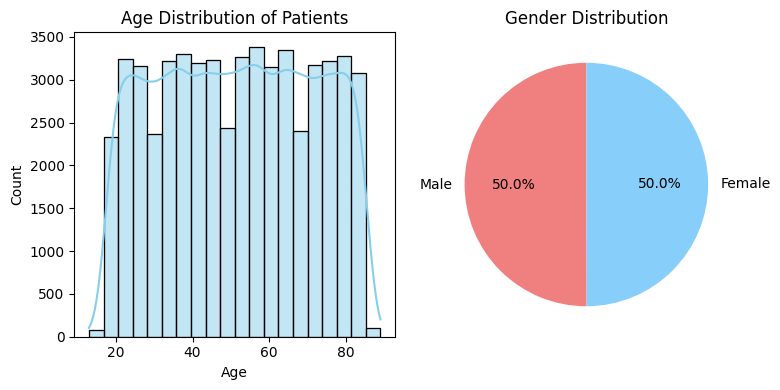

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Age distribution
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue', ax=ax1)
ax1.set_title('Age Distribution of Patients')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

# Gender distribution
gender_counts = df['Gender'].value_counts()
ax2.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
        colors=['lightcoral', 'lightskyblue'], startangle=90)
ax2.set_title('Gender Distribution')

plt.tight_layout()
plt.show()


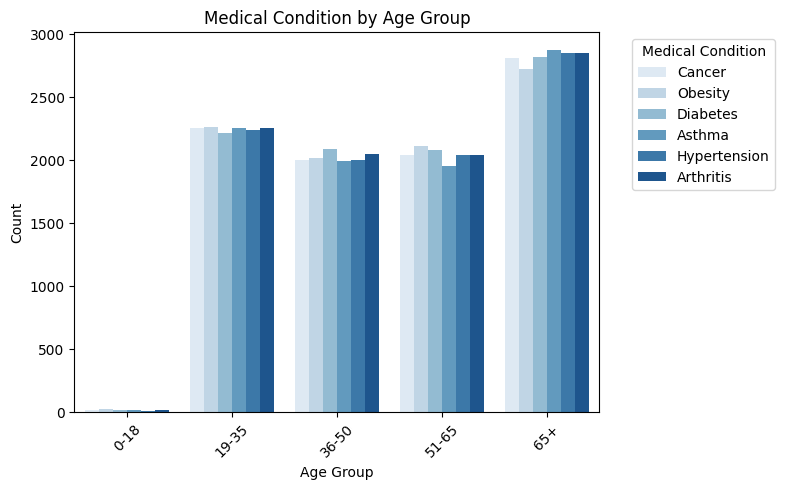

C:\Users\omara\AppData\Local\Temp\ipykernel_22876\444975784.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Admission Month', data=df, order=month_order, palette='Blues')


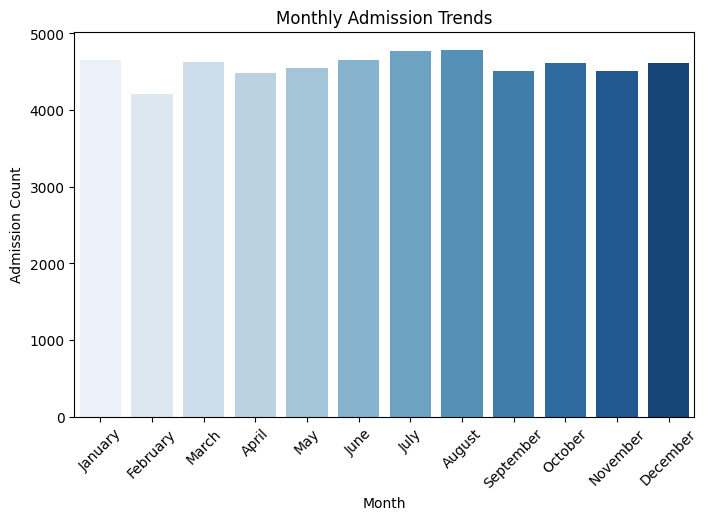

In [17]:
# Age groups
bins = [0, 18, 35, 50, 65, float('inf')]
labels = ['0-18', '19-35', '36-50', '51-65', '65+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Medical condition by age group
plt.figure(figsize=(8, 5))
sns.countplot(x='Age_Group', hue='Medical Condition', data=df, palette='Blues')
plt.title('Medical Condition by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Medical Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Monthly admission trends
df['Admission Month'] = df['Date of Admission'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(8, 5))
sns.countplot(x='Admission Month', data=df, order=month_order, palette='Blues')
plt.title('Monthly Admission Trends')
plt.xlabel('Month')
plt.ylabel('Admission Count')
plt.xticks(rotation=45)
plt.show()


## Data training

### XGBClassifier training model

#### Define Target & Select Features


In [18]:
# Define target variable
df['Condition_Label'] = df['Medical Condition']

# Select features and drop rows with missing values
features = ['Age', 'Gender', 'Blood Type', 'Billing Amount', 'Admission Type',
            'Length of Stay', 'Medication', 'Test Results']
df_model = df[features + ['Condition_Label']].dropna()


#### Encode & Standardize Features

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

# ✅ Step 0: Encode the target safely
df = df.dropna(subset=["Medical Condition"])  # Drop rows with missing labels

# Encode Medical Condition as multiclass label
label_encoder = LabelEncoder()
df["Condition_Label"] = label_encoder.fit_transform(df["Medical Condition"])
joblib.dump(label_encoder, "label_encoder.pkl")  # Save label encoder

# ✅ Step 1: Load and prepare the data (features + multiclass target)
df_model = df[[  # all selected features
    'Age', 'Gender', 'Blood Type', 'Billing Amount', 'Admission Type',
    'Length of Stay', 'Medication', 'Test Results', 'Condition_Label'
]]

# ✅ Step 2: Separate features and target
X = df_model.drop("Condition_Label", axis=1)
y = df_model["Condition_Label"]

# ✅ Step 3: One-hot encode categorical features
X_encoded = pd.get_dummies(X)
joblib.dump(X_encoded.columns.tolist(), "feature_columns.pkl")  # Save for app input alignment

# ✅ Step 4: Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
joblib.dump(scaler, "scaler.pkl")  # Save for inference

# ✅ Step 5: Apply SMOTE for class balance
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

print("✅ Data prepared: One-hot encoded, scaled, SMOTE applied, and label encoder saved.")


C:\Users\omara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\omara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

✅ Data prepared: One-hot encoded, scaled, SMOTE applied, and label encoder saved.


#### Train XGBoost Model

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# ✅ Determine number of unique classes
num_classes = len(np.unique(y_resampled))

# ✅ Train XGBoost with proper multiclass settings
model = XGBClassifier(
    objective='multi:softprob',       # Multiclass probability output
    num_class=num_classes,            # Total number of distinct condition labels
    use_label_encoder=False,          # Don't use legacy encoder
    eval_metric='mlogloss',           # Suitable for multiclass classification
    random_state=42
)

model.fit(X_train, y_train)


C:\Users\omara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:52:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6, ...)

#### Evaluate the Model

In [21]:

# Make predictions and class probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Multiclass ROC AUC using One-vs-Rest strategy
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC AUC (OvR): {roc_auc:.2f}")


Confusion Matrix:
 [[357 294 314 267 292 319]
 [285 380 298 295 285 300]
 [297 340 364 280 261 302]
 [280 292 303 365 295 309]
 [298 297 293 332 330 294]
 [324 266 310 246 299 399]]

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.19      0.19      1843
           1       0.20      0.21      0.20      1843
           2       0.19      0.20      0.20      1844
           3       0.20      0.20      0.20      1844
           4       0.19      0.18      0.18      1844
           5       0.21      0.22      0.21      1844

    accuracy                           0.20     11062
   macro avg       0.20      0.20      0.20     11062
weighted avg       0.20      0.20      0.20     11062

Accuracy: 0.20
ROC AUC (OvR): 0.53


#### saving XGBoost model 

In [22]:
joblib.dump(model, "xgb_diabetes_model.pkl")


['xgb_diabetes_model.pkl']

#### plotting

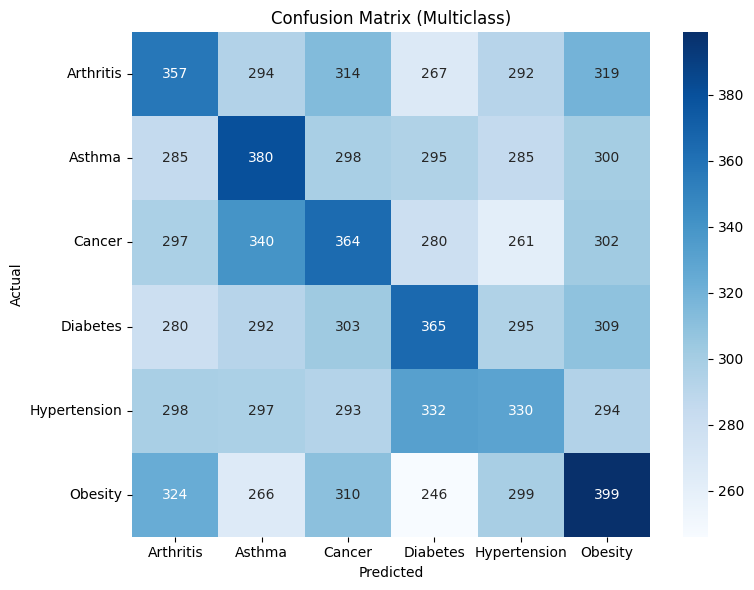

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load label encoder (you already saved it earlier)
label_encoder = joblib.load("label_encoder.pkl")
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Multiclass)')
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


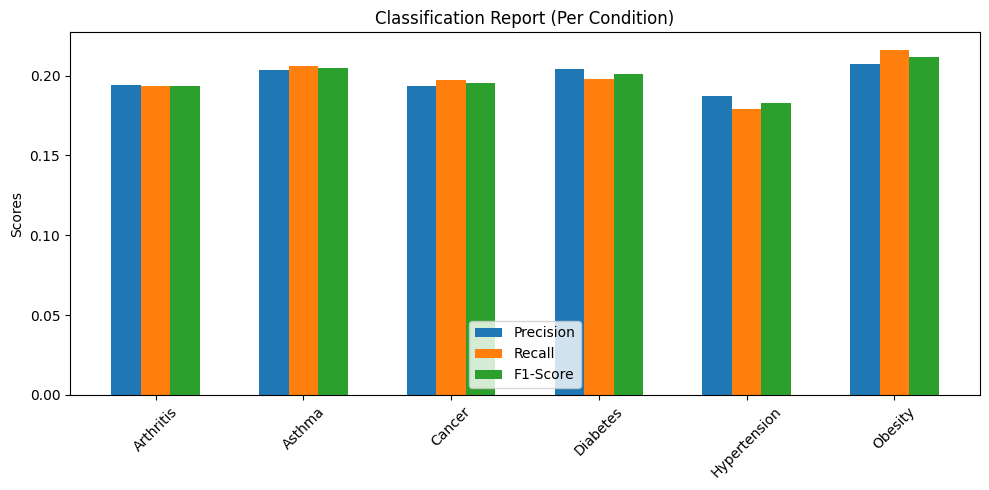

In [24]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Classification report as dict
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Load label encoder to get proper class labels
label_encoder = joblib.load("label_encoder.pkl")
classes = label_encoder.classes_

# Extract scores
precision = [report_dict[str(i)]['precision'] for i in range(len(classes))]
recall = [report_dict[str(i)]['recall'] for i in range(len(classes))]
f1_score = [report_dict[str(i)]['f1-score'] for i in range(len(classes))]

# Plot
x = np.arange(len(classes))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Classification Report (Per Condition)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()
fig.tight_layout()
plt.show()


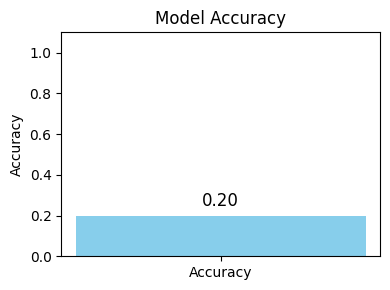

In [25]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Plot
plt.figure(figsize=(4, 3))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim([0, 1.1])  # Leave room for label
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.text(0, min(accuracy + 0.03, 1.05), f'{accuracy:.2f}', ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


### Random Forest Classifier

#### Split and Train the Model

In [26]:


# Train Random Forest on dummy-encoded, scaled, and SMOTE-balanced data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Save the model
joblib.dump(rf_model, "diabetes_rf_model.pkl")
print("✅ Random Forest model saved.")


✅ Random Forest model saved.


#### Predict and Evaluate

In [27]:

# Optional: Train-test split from resampled data (for testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate
print("✅ Evaluation of Random Forest:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


✅ Evaluation of Random Forest:
[[1834    0    0    0    0    0]
 [   0 1898    0    0    0    0]
 [   0    0 1795    0    0    0]
 [   0    0    0 1893    0    0]
 [   0    0    0    0 1812    0]
 [   0    0    0    0    0 1830]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1834
           1       1.00      1.00      1.00      1898
           2       1.00      1.00      1.00      1795
           3       1.00      1.00      1.00      1893
           4       1.00      1.00      1.00      1812
           5       1.00      1.00      1.00      1830

    accuracy                           1.00     11062
   macro avg       1.00      1.00      1.00     11062
weighted avg       1.00      1.00      1.00     11062

Accuracy: 1.00


#### saving random forrest model 

In [28]:
# Save the correct Random Forest model trained on dummy-encoded + SMOTE data
joblib.dump(rf_model, "diabetes_rf_model.pkl")
print("✅ Random Forest model saved.")


✅ Random Forest model saved.


#### plotting 

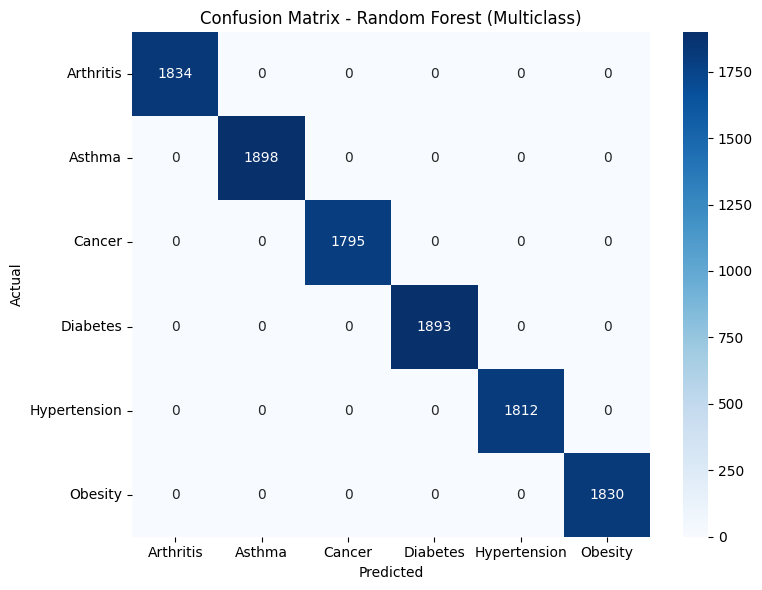

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix

# Load the label encoder used during training
label_encoder = joblib.load("label_encoder.pkl")
class_names = label_encoder.classes_

# Plot confusion matrix with actual class names
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix - Random Forest (Multiclass)')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


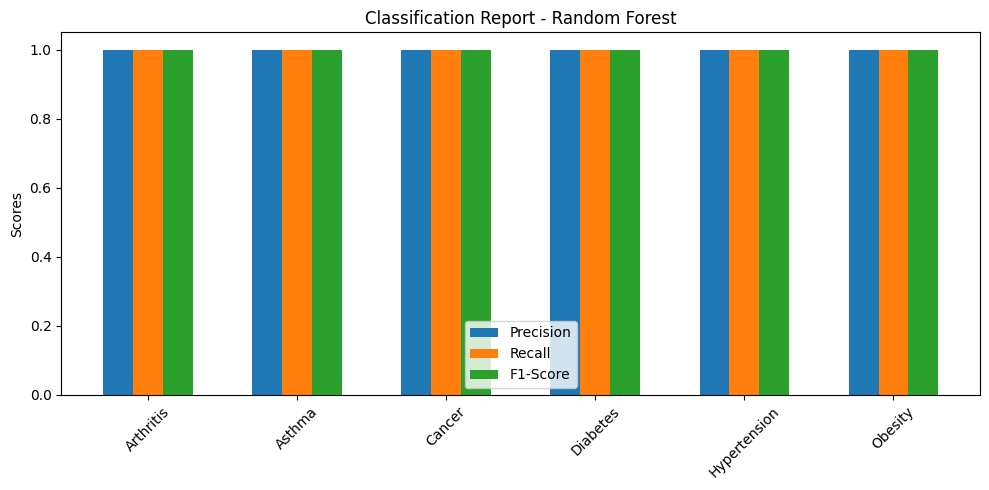

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib

# Load label encoder to get condition names
label_encoder = joblib.load("label_encoder.pkl")
class_names = label_encoder.classes_

# Generate classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Extract scores for each class
precision = [report_dict[str(i)]['precision'] for i in range(len(class_names))]
recall = [report_dict[str(i)]['recall'] for i in range(len(class_names))]
f1_score = [report_dict[str(i)]['f1-score'] for i in range(len(class_names))]

# Plotting
x = np.arange(len(class_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Classification Report - Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


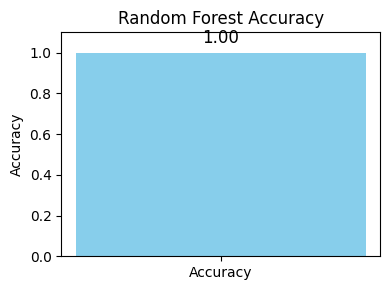

In [31]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Plot
plt.figure(figsize=(4, 3))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim([0, 1.1])  # Add space for label above the bar
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy')
plt.text(0, min(accuracy + 0.03, 1.05), f'{accuracy:.2f}', ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


### CatBoostClassifier

#### Target setup 

In [32]:
df['Condition_Label'] = df['Medical Condition']  # Multiclass target


#### Feature Selection & Encoding

In [33]:
# Define features
features = ['Age', 'Gender', 'Blood Type', 'Billing Amount', 'Admission Type',
            'Length of Stay', 'Medication', 'Test Results']

# Use multiclass label
df_model = df[features + ['Condition_Label']].dropna()

X = df_model.drop("Condition_Label", axis=1)
y_raw = df_model["Condition_Label"]

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
joblib.dump(label_encoder, "label_encoder.pkl")  # Save encoder

# One-hot encode features
X_encoded = pd.get_dummies(X)

# OPTIONAL: Save structure if you haven't already
joblib.dump(X_encoded.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']

#### Oversampling + Training

In [34]:
# Apply SMOTE to handle class imbalance
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_encoded, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train CatBoost (no need to specify cat_features with dummies)
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)


#### Evaluation

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Predict labels and probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # Needed for multiclass AUC

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Multiclass ROC AUC (One-vs-Rest)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC AUC (OvR): {roc_auc:.2f}")


Confusion Matrix:
 [[347 278 282 310 301 316]
 [282 362 316 298 307 333]
 [238 299 402 282 284 290]
 [282 272 325 367 326 321]
 [263 301 287 283 362 316]
 [313 268 282 286 282 399]]

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.19      0.19      1834
           1       0.20      0.19      0.20      1898
           2       0.21      0.22      0.22      1795
           3       0.20      0.19      0.20      1893
           4       0.19      0.20      0.20      1812
           5       0.20      0.22      0.21      1830

    accuracy                           0.20     11062
   macro avg       0.20      0.20      0.20     11062
weighted avg       0.20      0.20      0.20     11062

Accuracy: 0.20
ROC AUC (OvR): 0.54


#### saving CatBoost model 

In [36]:
# Save CatBoost model only (feature_columns already saved)
joblib.dump(model, "catboost_diabetes_model.pkl")
print("✅ CatBoost model saved.")


✅ CatBoost model saved.


#### plotting 

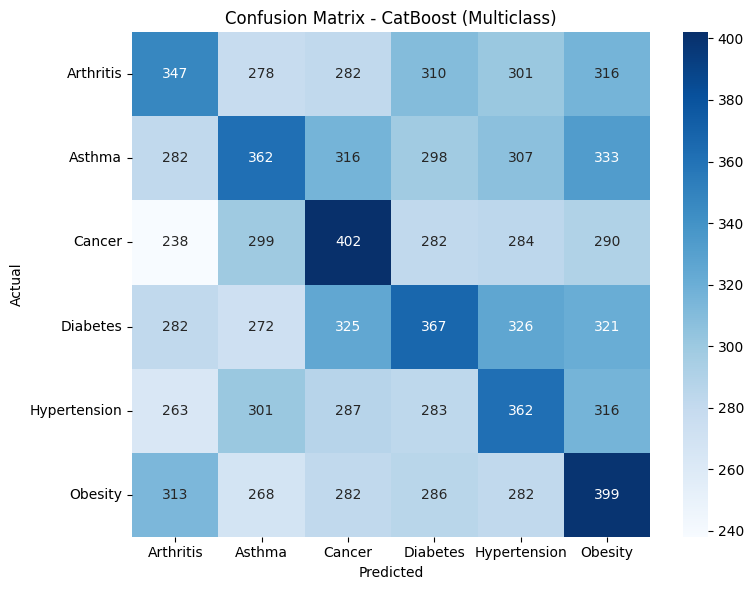

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix

# Load the label encoder to decode class indices to names
label_encoder = joblib.load("label_encoder.pkl")
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix - CatBoost (Multiclass)')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


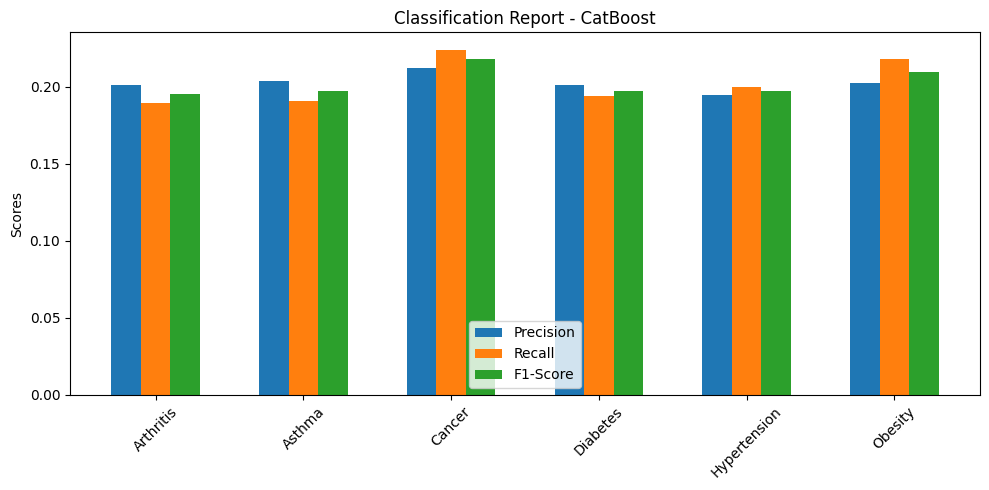

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib

# Load label encoder to get actual class names
label_encoder = joblib.load("label_encoder.pkl")
class_names = label_encoder.classes_

# Generate classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, F1-score for each class
precision = [report_dict[str(i)]['precision'] for i in range(len(class_names))]
recall = [report_dict[str(i)]['recall'] for i in range(len(class_names))]
f1_score = [report_dict[str(i)]['f1-score'] for i in range(len(class_names))]

# Plot setup
x = np.arange(len(class_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# Formatting
ax.set_ylabel('Scores')
ax.set_title('Classification Report - CatBoost')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
fig.tight_layout()

# Show plot
plt.show()


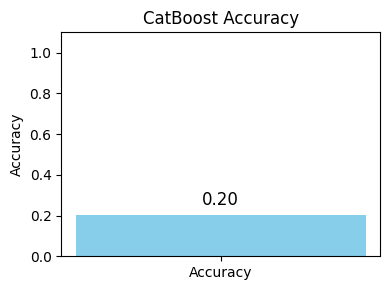

In [39]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Plot accuracy bar
plt.figure(figsize=(4, 3))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim([0, 1.1])  # Add space above for label
plt.ylabel('Accuracy')
plt.title('CatBoost Accuracy')

# Add accuracy label above the bar
plt.text(0, min(accuracy + 0.03, 1.05), f'{accuracy:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


# **Model Optimization**

#### Accuracy Optimization via Grid Search

In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Get number of unique classes
num_classes = len(np.unique(y_train))

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize GridSearchCV for multiclass XGBoost
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=num_classes,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Output best results
print("✅ Best parameters (accuracy):", grid_search.best_params_)
print(f"✅ Best cross-validated accuracy: {grid_search.best_score_:.2f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\omara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:58:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best parameters (accuracy): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
✅ Best cross-validated accuracy: 0.22


#### Evaluate Best Accuracy Model with Thresholds

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict labels and probabilities
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Accuracy
print(f"\n🎯 Accuracy of best model: {accuracy_score(y_test, y_pred):.2f}")

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Multiclass ROC AUC
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC AUC (OvR): {roc_auc:.2f}")



🎯 Accuracy of best model: 0.23
Confusion Matrix:
[[387 251 301 291 293 311]
 [251 420 304 321 278 324]
 [258 271 423 260 290 293]
 [290 281 296 428 301 297]
 [252 281 262 291 421 305]
 [267 268 303 284 268 440]]

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22      1834
           1       0.24      0.22      0.23      1898
           2       0.22      0.24      0.23      1795
           3       0.23      0.23      0.23      1893
           4       0.23      0.23      0.23      1812
           5       0.22      0.24      0.23      1830

    accuracy                           0.23     11062
   macro avg       0.23      0.23      0.23     11062
weighted avg       0.23      0.23      0.23     11062

ROC AUC (OvR): 0.56


#### saving optimized XGBoost model 

In [42]:
joblib.dump(best_model, "optimized_xgb_model.pkl")
print("✅ Optimized model saved as 'optimized_xgb_model.pkl'")


✅ Optimized model saved as 'optimized_xgb_model.pkl'


#### Optimize for Recall

In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Get number of classes
num_classes = len(np.unique(y_train))

# Use recall_macro to score recall across all classes
recall_grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=num_classes,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='recall_macro',  # ✅ multiclass-safe
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit grid search
recall_grid.fit(X_train, y_train)

# Output results
print("🔍 Best parameters (recall):", recall_grid.best_params_)
print(f"🔍 Best cross-validated recall score: {recall_grid.best_score_:.2f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\omara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [00:00:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 Best parameters (recall): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
🔍 Best cross-validated recall score: 0.22


#### Evaluation 

In [44]:
from sklearn.metrics import recall_score, classification_report

# Get best recall-optimized model
recall_model = recall_grid.best_estimator_

# Predict on test set
y_pred_recall = recall_model.predict(X_test)

# Evaluate using macro recall
recall_value = recall_score(y_test, y_pred_recall, average='macro')
print(f"✅ Macro-Averaged Recall of Recall-Optimized Model: {recall_value:.2f}")

# Full classification report
print("\n📋 Full Classification Report:")
print(classification_report(y_test, y_pred_recall, zero_division=0))


✅ Macro-Averaged Recall of Recall-Optimized Model: 0.23

📋 Full Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22      1834
           1       0.24      0.22      0.23      1898
           2       0.22      0.24      0.23      1795
           3       0.23      0.23      0.23      1893
           4       0.23      0.23      0.23      1812
           5       0.22      0.24      0.23      1830

    accuracy                           0.23     11062
   macro avg       0.23      0.23      0.23     11062
weighted avg       0.23      0.23      0.23     11062



#### Save the Recall-Optimized Model

In [45]:


# Save the best estimator optimized for recall
joblib.dump(recall_grid.best_estimator_, "xgb_recall_model.pkl")
print("✅ Recall-optimized XGBoost model saved as 'xgb_recall_model.pkl'")


✅ Recall-optimized XGBoost model saved as 'xgb_recall_model.pkl'


#### plotting 

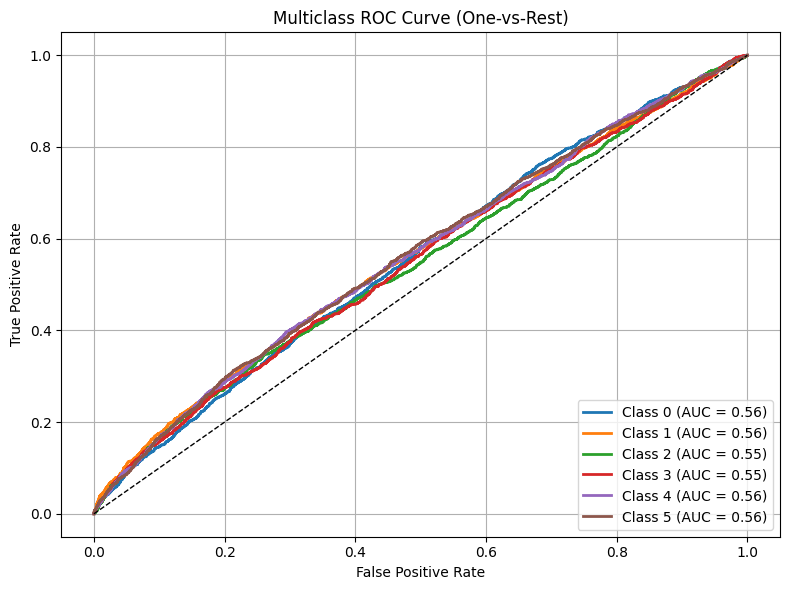

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize y_test for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # shape: (n_samples, n_classes)
n_classes = y_test_bin.shape[1]

# Initialize figure
plt.figure(figsize=(8, 6))

# Plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


### MLOP Implementation**

#### Set MLflow Experiment and Train Model

In [47]:
"""
# Set the MLflow experiment name
mlflow.set_experiment("disease_prediction_xgboost")

# Define hyperparameter grid (could be expanded later)
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [100],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.9]
}

# Grid search for best model
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
"""


'\n# Set the MLflow experiment name\nmlflow.set_experiment("disease_prediction_xgboost")\n\n# Define hyperparameter grid (could be expanded later)\nparam_grid = {\n    \'learning_rate\': [0.1],\n    \'n_estimators\': [100],\n    \'max_depth\': [5],\n    \'subsample\': [0.9],\n    \'colsample_bytree\': [0.9]\n}\n\n# Grid search for best model\ngrid_search = GridSearchCV(\n    estimator=XGBClassifier(use_label_encoder=False, eval_metric=\'logloss\', random_state=42),\n    param_grid=param_grid,\n    scoring=\'accuracy\',\n    cv=5,\n    n_jobs=-1,\n    verbose=1\n)\n\ngrid_search.fit(X_train, y_train)\nbest_model = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\n'

#### MLflow Logging

In [48]:
"""
# Start MLflow logging
with mlflow.start_run(run_name="XGBoost_Classifier_Tuned"):

    # Log parameters and accuracy
    acc = accuracy_score(y_test, y_pred)
    mlflow.log_param("model_type", "XGBoostClassifier")
    for param, value in grid_search.best_params_.items():
        mlflow.log_param(param, value)
    mlflow.log_metric("accuracy", acc)

    # Save classification report
    report = classification_report(y_test, y_pred, zero_division=0)
    os.makedirs("mlruns_artifacts", exist_ok=True)
    with open("mlruns_artifacts/classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("mlruns_artifacts/classification_report.txt")

    # Save and log confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("mlruns_artifacts/confusion_matrix.png")
    mlflow.log_artifact("mlruns_artifacts/confusion_matrix.png")

    # Log the trained model
    mlflow.sklearn.log_model(best_model, "model")
"""

'\n# Start MLflow logging\nwith mlflow.start_run(run_name="XGBoost_Classifier_Tuned"):\n\n    # Log parameters and accuracy\n    acc = accuracy_score(y_test, y_pred)\n    mlflow.log_param("model_type", "XGBoostClassifier")\n    for param, value in grid_search.best_params_.items():\n        mlflow.log_param(param, value)\n    mlflow.log_metric("accuracy", acc)\n\n    # Save classification report\n    report = classification_report(y_test, y_pred, zero_division=0)\n    os.makedirs("mlruns_artifacts", exist_ok=True)\n    with open("mlruns_artifacts/classification_report.txt", "w") as f:\n        f.write(report)\n    mlflow.log_artifact("mlruns_artifacts/classification_report.txt")\n\n    # Save and log confusion matrix plot\n    cm = confusion_matrix(y_test, y_pred)\n    plt.figure(figsize=(6, 5))\n    sns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\')\n    plt.title("Confusion Matrix")\n    plt.xlabel("Predicted")\n    plt.ylabel("Actual")\n    plt.tight_layout()\n    plt.savefig("ml

#### Start MLflow UI + Ngrok

In [49]:
"""
# Launch MLflow UI in the background (Colab / Jupyter)
get_ipython().system_raw("mlflow ui --port 5000 &")
"""

'\n# Launch MLflow UI in the background (Colab / Jupyter)\nget_ipython().system_raw("mlflow ui --port 5000 &")\n'

#### Expose MLflow UI via Ngrok

In [50]:
"""
# ⚠️ Tip: For security, store token in an environment variable or config file in real use
ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN_HERE")  # Replace or use env variable
public_url = ngrok.connect(5000)
print("🔗 MLflow Tracking UI:", public_url)
"""


'\n# ⚠️ Tip: For security, store token in an environment variable or config file in real use\nngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN_HERE")  # Replace or use env variable\npublic_url = ngrok.connect(5000)\nprint("🔗 MLflow Tracking UI:", public_url)\n'